## Modeling Airfare Prediction

We will be going through a short review of the last notebook and do a deeper dive into another model for our data. We will then conduct the model selection process. We will also be tuning the hyperparameters and features that will be used in our model.

In [3]:
# Import relevant libraries and packages.
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

import datetime

In [4]:
fare_data = pd.read_csv('../data/airfare_data_step3_features.csv')

In [5]:
fare_data.head()

,Date_of_journey,Journey_day,Airline,Flight_code,Class,Source,Departure,Total_stops,Arrival,Destination,Duration_in_hours,Days_left,Fare,Month,Day,Part of the month,Route,Booking_Category
0,2023-01-16,Monday,SpiceJet,SG-8169,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.0833,1,5335,1,16,Middle,Delhi to Mumbai,Last-minute
1,2023-01-16,Monday,Indigo,6E-2519,Economy,Delhi,After 6 PM,non-stop,Before 6 AM,Mumbai,2.3333,1,5899,1,16,Middle,Delhi to Mumbai,Last-minute
2,2023-01-16,Monday,GO FIRST,G8-354,Economy,Delhi,After 6 PM,non-stop,Before 6 AM,Mumbai,2.1667,1,5801,1,16,Middle,Delhi to Mumbai,Last-minute
3,2023-01-16,Monday,SpiceJet,SG-8709,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.0833,1,5794,1,16,Middle,Delhi to Mumbai,Last-minute
4,2023-01-16,Monday,Air India,AI-805,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.1667,1,5955,1,16,Middle,Delhi to Mumbai,Last-minute


In [6]:
fare = fare_data['Fare']

In [7]:
af_data = pd.read_csv('../data/airfare_pricing_model.pkl')

In [8]:
af_data.head()

,Journey_day_Monday,Journey_day_Saturday,Journey_day_Sunday,Journey_day_Thursday,Journey_day_Tuesday,Journey_day_Wednesday,Airline_AirAsia,Airline_AkasaAir,Airline_AllianceAir,Airline_GO FIRST,...,Route_Kolkata to Hyderabad,Route_Kolkata to Mumbai,Route_Mumbai to Ahmedabad,Route_Mumbai to Bangalore,Route_Mumbai to Chennai,Route_Mumbai to Delhi,Route_Mumbai to Hyderabad,Route_Mumbai to Kolkata,Booking_Category_Planned,Booking_Category_Short-notice
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [9]:
af_data.columns

Index(['Journey_day_Monday', 'Journey_day_Saturday', 'Journey_day_Sunday',
       'Journey_day_Thursday', 'Journey_day_Tuesday', 'Journey_day_Wednesday',
       'Airline_AirAsia', 'Airline_AkasaAir', 'Airline_AllianceAir',
       'Airline_GO FIRST', 'Airline_Indigo', 'Airline_SpiceJet',
       'Airline_StarAir', 'Airline_Vistara', 'Class_Premium',
       'Total_stops_2+-stop', 'Total_stops_non-stop', 'Arrival_6 AM - 12 PM',
       'Arrival_After 6 PM', 'Arrival_Before 6 AM', 'Departure_6 AM - 12 PM',
       'Departure_After 6 PM', 'Departure_Before 6 AM',
       'Part of the month_End', 'Part of the month_Middle',
       'Route_Ahmedabad to Chennai', 'Route_Ahmedabad to Delhi',
       'Route_Ahmedabad to Hyderabad', 'Route_Ahmedabad to Kolkata',
       'Route_Ahmedabad to Mumbai', 'Route_Bangalore to Ahmedabad',
       'Route_Bangalore to Chennai', 'Route_Bangalore to Delhi',
       'Route_Bangalore to Hyderabad', 'Route_Bangalore to Kolkata',
       'Route_Bangalore to Mumbai', 'Route

## Train/Test Split and Creating Metrics

In [11]:
X_train, X_test, y_train, y_test = train_test_split(af_data, fare, test_size=0.3, random_state = 47)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(311756, 68) (133610, 68) (311756,) (133610,)


In [12]:
#Calculate the R^2
def r_squared(y, ypred):
    """R-squared score.
    
    Calculate the R-squared, or coefficient of determination, of the input.
    
    Arguments:
    y -- the observed values
    ypred -- the predicted values
    """
    ybar = np.sum(y) / len(y) #yes, we could use np.mean(y)
    sum_sq_tot = np.sum((y - ybar)**2) #total sum of squares error
    sum_sq_res = np.sum((y - ypred)**2) #residual sum of squares error
    R2 = 1.0 - sum_sq_res / sum_sq_tot
    return R2

In [13]:
#Calculate the MAE
def mae(y, ypred):
    """Mean absolute error.
    
    Calculate the mean absolute error of the arguments

    Arguments:
    y -- the observed values
    ypred -- the predicted values
    """
    abs_error = np.abs(y - ypred)
    mae = np.mean(abs_error)
    return mae

In [14]:
#Calculate the MSE which tells us how close a regression line is to a set of data points
# a good model will have an MSE closer to 0, indicating a better goodness of fit to the data
def mse(y, ypred):
    """Mean square error.
    
    Calculate the mean square error of the arguments

    Arguments:
    y -- the observed values
    ypred -- the predicted values
    """
    sq_error = (y - ypred)**2
    mse = np.mean(sq_error)
    return mse

From the previous notebook, we looked at the Linear regression model and the Gradient Boosting Model. The Gradient boosting regressor outperformed the linear regressor. We will also conduct some analysis on the Histogram Gradient Boosting Regressor. Then we will compare these two and do the final model selection.

## Gradient Boosting Regressor

Let's test our data on a different type of model, Gradient Boosting Regressor. It may be more optimal for our dataset because it is better at handling complex datasets such as ours and it is robust to outliers which our dataset is abundant in.

In [18]:
GB_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    GradientBoostingRegressor(random_state=47)
)

In [19]:
gb_default_cv_results = cross_validate(GB_pipe, X_train, y_train, cv=3)

In [20]:
gb_cv_scores = gb_default_cv_results['test_score']
gb_cv_scores

array([0.60436444, 0.60465871, 0.60254929])

In [21]:
np.mean(gb_cv_scores), np.std(gb_cv_scores)

(0.603857480289744, 0.0009328014012020125)

These numbers will inevitably be different to those in the previous step that used a different training data set. They should, however, be consistent. It's important to appreciate that estimates of model performance are subject to the noise and uncertainty of data!

In [22]:
params = {
    'gradientboostingregressor__n_estimators': [50, 100, 200],
    'gradientboostingregressor__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'gradientboostingregressor__max_depth': [3, 5, 7],
    'gradientboostingregressor__min_samples_split': [2, 5, 10]
}

In [23]:
random_search = RandomizedSearchCV(estimator=GB_pipe, param_distributions=params,
                                   n_iter=25, cv=3, n_jobs=-1, verbose=2, random_state=42)

In [24]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END gradientboostingregressor__learning_rate=0.2, gradientboostingregressor__max_depth=7, gradientboostingregressor__min_samples_split=5, gradientboostingregressor__n_estimators=200; total time= 5.5min
[CV] END gradientboostingregressor__learning_rate=0.1, gradientboostingregressor__max_depth=3, gradientboostingregressor__min_samples_split=5, gradientboostingregressor__n_estimators=50; total time=  39.0s
[CV] END gradientboostingregressor__learning_rate=0.3, gradientboostingregressor__max_depth=5, gradientboostingregressor__min_samples_split=5, gradientboostingregressor__n_estimators=200; total time= 4.0min
[CV] END gradientboostingregressor__learning_rate=0.2, gradientboostingregressor__max_depth=7, gradientboostingregressor__min_samples_split=10, gradientboostingregressor__n_estimators=100; total time= 2.8min
[CV] END gradientboostingregressor__learning_rate=0.2, gradientboostingregressor__max_depth=3, gradientboosting

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('simpleimputer',
                                              SimpleImputer(strategy='median')),
                                             ('gradientboostingregressor',
                                              GradientBoostingRegressor(random_state=47))]),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'gradientboostingregressor__learning_rate': [0.01,
                                                                                     0.1,
                                                                                     0.2,
                                                                                     0.3],
                                        'gradientboostingregressor__max_depth': [3,
                                                                                 5,
                                                                                 7],
                                        'gradientboostingregressor__min_samples_split': [2,
                                                                                         5,
                                                                                         10],
                                        'gradientboostingregressor__n_estimators': [50,
                                                                                    100,
                                                                                    200]},
                   random_state=42, verbose=2)

In [25]:
print("Best parameters found by RandomizedSearchCV:", random_search.best_params_)

Best parameters found by RandomizedSearchCV: {'gradientboostingregressor__n_estimators': 200, 'gradientboostingregressor__min_samples_split': 10, 'gradientboostingregressor__max_depth': 7, 'gradientboostingregressor__learning_rate': 0.2}


In [26]:
gb_best_cv_results = cross_validate(random_search.best_estimator_, X_train, y_train, cv=3)
gb_best_scores = gb_best_cv_results['test_score']
gb_best_scores

[CV] END gradientboostingregressor__learning_rate=0.01, gradientboostingregressor__max_depth=3, gradientboostingregressor__min_samples_split=5, gradientboostingregressor__n_estimators=100; total time= 1.4min
[CV] END gradientboostingregressor__learning_rate=0.01, gradientboostingregressor__max_depth=3, gradientboostingregressor__min_samples_split=5, gradientboostingregressor__n_estimators=100; total time= 1.2min
[CV] END gradientboostingregressor__learning_rate=0.2, gradientboostingregressor__max_depth=3, gradientboostingregressor__min_samples_split=10, gradientboostingregressor__n_estimators=200; total time= 2.4min
[CV] END gradientboostingregressor__learning_rate=0.1, gradientboostingregressor__max_depth=3, gradientboostingregressor__min_samples_split=5, gradientboostingregressor__n_estimators=50; total time=  38.2s
[CV] END gradientboostingregressor__learning_rate=0.1, gradientboostingregressor__max_depth=7, gradientboostingregressor__min_samples_split=2, gradientboostingregressor__

array([0.65557833, 0.65894419, 0.65344525])

In [27]:
np.mean(gb_best_scores), np.std(gb_best_scores)

(0.655989254899917, 0.002263660941740931)

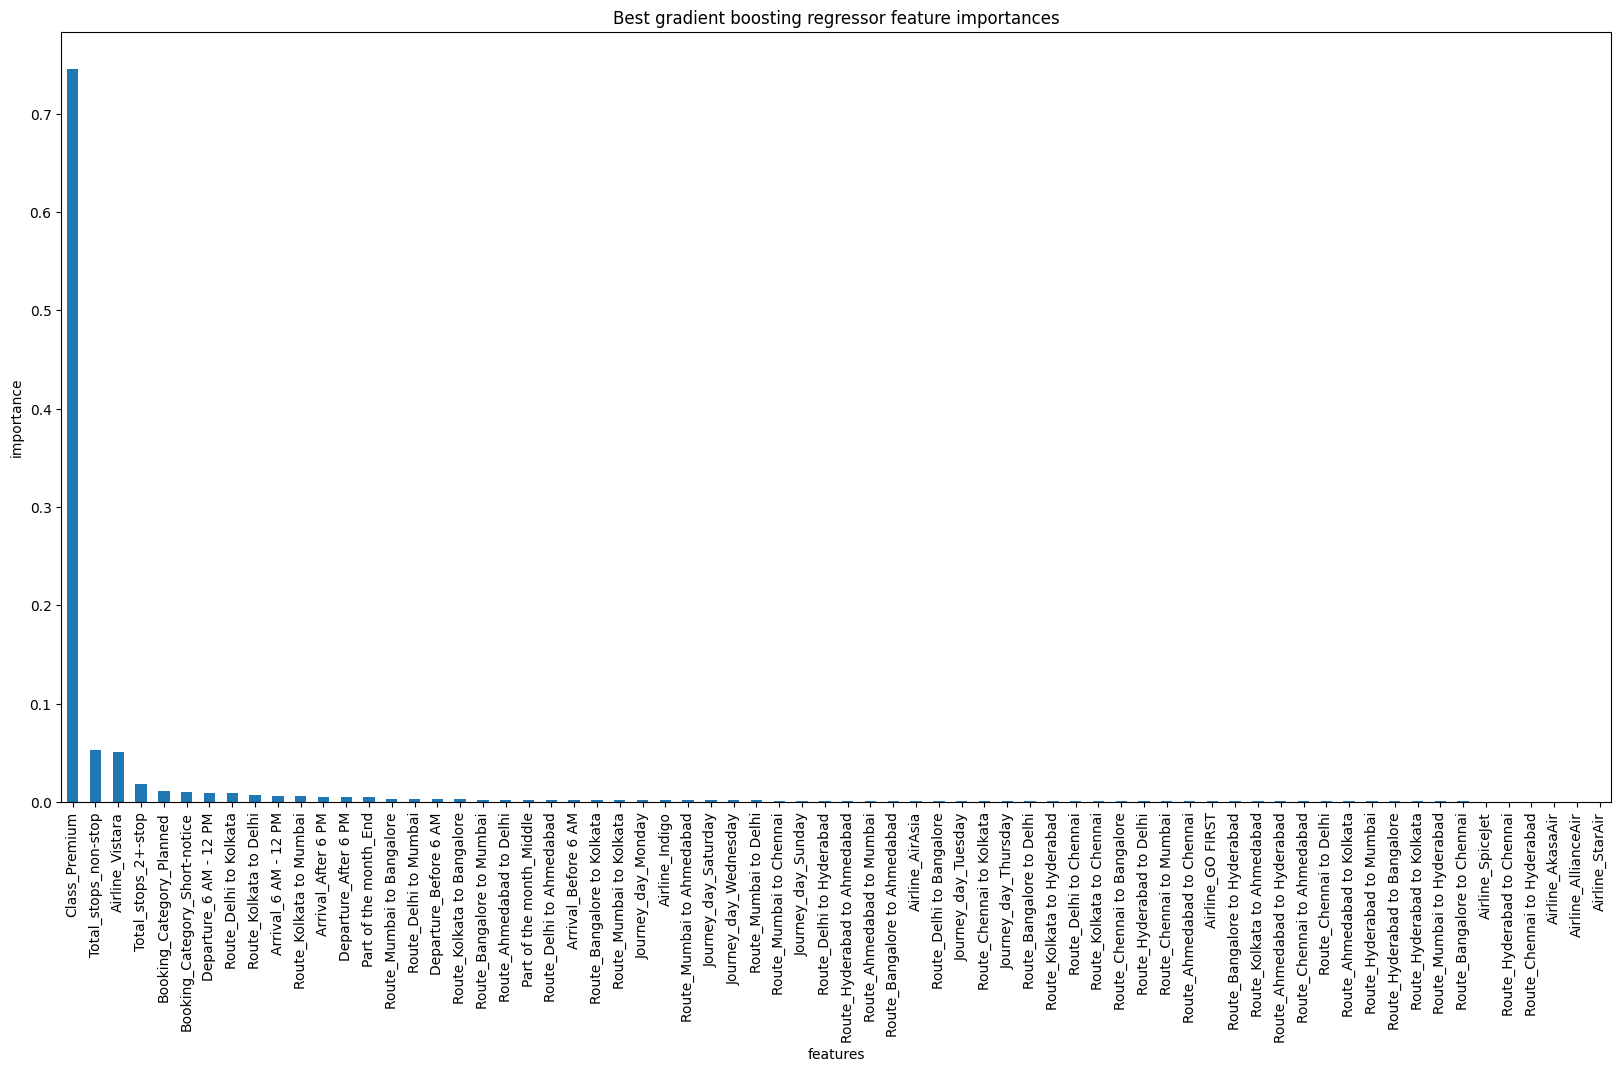

In [28]:
plt.subplots(figsize=(20, 10))
imps = random_search.best_estimator_.named_steps['gradientboostingregressor'].feature_importances_

gb_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
gb_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best gradient boosting regressor feature importances');

The dominant features are:
* Class_Premium
* Total_stops_non-stop
* Airline_Vistara
* Total_stops_2+-stop

## Histogram Gradient Boosting Regressor

After further research I have decided to also try the histogram gradient boosting regressor. It can greatly reduce computation time and could be perfect for the high dimensional categorical dataset.

In [32]:
HGB_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    HistGradientBoostingRegressor(random_state=47)
)

In [33]:
hgb_default_cv_results = cross_validate(HGB_pipe, X_train, y_train, cv=3)

In [34]:
hgb_cv_scores = hgb_default_cv_results['test_score']
hgb_cv_scores

array([0.63989991, 0.64215849, 0.6371224 ])

In [35]:
np.mean(hgb_cv_scores), np.std(hgb_cv_scores)

(0.6397269370443232, 0.002059610223642216)

In [36]:
params = {
     'histgradientboostingregressor__learning_rate': [0.01, 0.05, 0.1],
    'histgradientboostingregressor__max_iter': [100, 200, 300, 500],
    'histgradientboostingregressor__max_depth': [3, 5, 10, None],
    'histgradientboostingregressor__min_samples_leaf': [1, 10, 20, 50],
    'histgradientboostingregressor__max_leaf_nodes': [10, 20, 31, 50],
    'histgradientboostingregressor__l2_regularization': [0, 0.01, 0.1, 1]
}

In [37]:
random_search = RandomizedSearchCV(estimator=HGB_pipe, param_distributions=params,
                                   n_iter=25, cv=3, random_state=42, n_jobs=-1)

In [38]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('simpleimputer',
                                              SimpleImputer(strategy='median')),
                                             ('histgradientboostingregressor',
                                              HistGradientBoostingRegressor(random_state=47))]),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'histgradientboostingregressor__l2_regularization': [0,
                                                                                             0.01,
                                                                                             0.1,
                                                                                             1],
                                        'histgradientboostingregressor__learning_rate': [0.01,
                                                                                         0.05,
                                                                                         0.1],
                                        'histgradientboostingregressor__max_depth': [3,
                                                                                     5,
                                                                                     10,
                                                                                     None],
                                        'histgradientboostingregressor__max_iter': [100,
                                                                                    200,
                                                                                    300,
                                                                                    500],
                                        'histgradientboostingregressor__max_leaf_nodes': [10,
                                                                                          20,
                                                                                          31,
                                                                                          50],
                                        'histgradientboostingregressor__min_samples_leaf': [1,
                                                                                            10,
                                                                                            20,
                                                                                            50]},
                   random_state=42)

In [39]:
print("Best parameters found by RandomizedSearchCV:", random_search.best_params_)

Best parameters found by RandomizedSearchCV: {'histgradientboostingregressor__min_samples_leaf': 50, 'histgradientboostingregressor__max_leaf_nodes': 50, 'histgradientboostingregressor__max_iter': 500, 'histgradientboostingregressor__max_depth': 10, 'histgradientboostingregressor__learning_rate': 0.05, 'histgradientboostingregressor__l2_regularization': 0.01}


In [49]:
hgb_best_cv_results = cross_validate(random_search.best_estimator_, X_train, y_train, cv=3)
hgb_best_scores = hgb_best_cv_results['test_score']
hgb_best_scores

array([0.64956688, 0.65154304, 0.64629114])

In [50]:
np.mean(gb_best_scores), np.std(gb_best_scores)

(0.6491336877624683, 0.002165847239007797)

In [51]:
np.round((np.mean(gb_best_scores) - 2 * np.std(gb_best_scores), np.mean(gb_best_scores) + 2 * np.std(gb_best_scores)), 2)

array([0.64, 0.65])

In [63]:
HGB_pipe.fit(X_train, y_train)
y_tr_pred = HGB_pipe.predict(X_train)
y_te_pred = HGB_pipe.predict(X_test)

In [64]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(7514.396283620079, 7557.521290079536)

In [69]:
GB_pipe.fit(X_train, y_train)
y_tr_pred = GB_pipe.predict(X_train)
y_te_pred = GB_pipe.predict(X_test)

In [70]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(8151.009149742733, 8176.4894543484725)

100%|===================| 133389/133610 [06:41<00:00]        

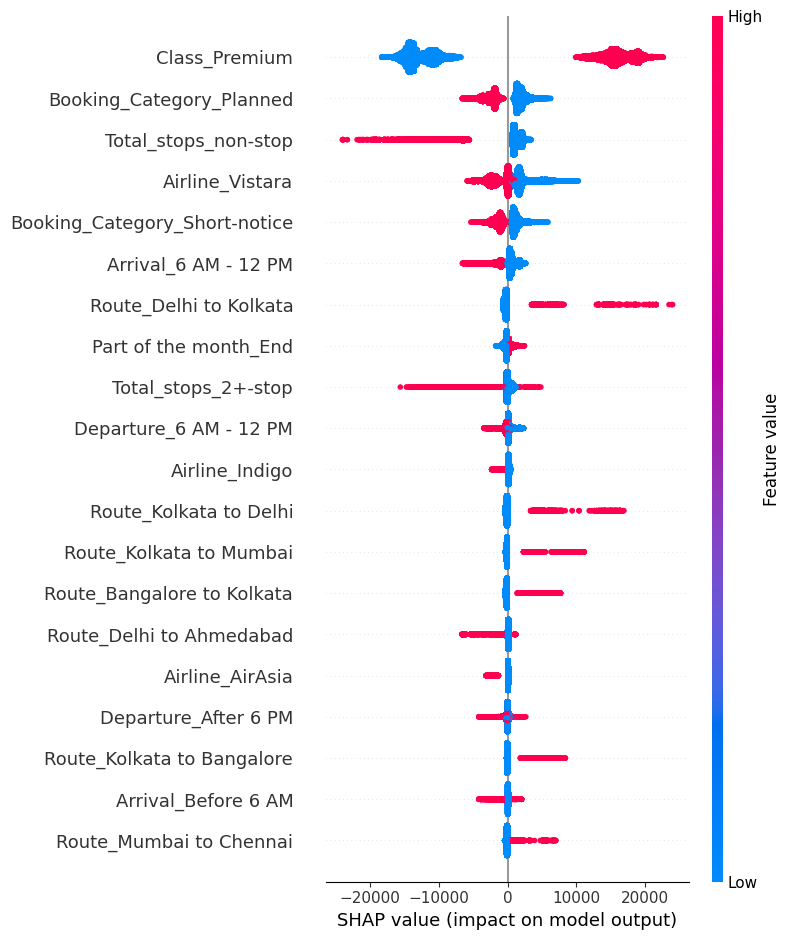

In [74]:
import shap

# Fit the model
HGB_pipe.fit(X_train, y_train)

# Initialize SHAP explainer
explainer = shap.Explainer(HGB_pipe.named_steps['histgradientboostingregressor'], X_train)
shap_values = explainer(X_test)

# Visualize feature importance
shap.summary_plot(shap_values, X_test)


We can see from the Shap plot that the HGB regressor model conveys that the most impactful features to the model are:
 * Class_Premium (positive, increasing price)
 * Total_stops_Non-stop (negative, decreasing price)
 * Route_Delhi_to_Kolkata
 * Total_stops_2+-stop

The Histogram Gradient Boosting Regressor model has a higher cross-validation mean score of about 0.64 and a mean absolute error lower than the gradient boosting regressor, by 600 rupies, at about 7500 rupies. They both have about the same amount of variability. Verifying performance on the test set produces performance consistent with the cross-validation results.

## Final Model Selection

We will be moving forward with the Histogram Gradient Boosting Regressor. It has overall a better performance on the dataset. This is most likely because the HGBR model has faster computational time due to its binning characteristic and its ability at handling large datasets.

## Calculate Expected Big Mountain Ticket Price From The Model

In [132]:
X_bm = af_data
y_bm = fare

In [134]:
bm_pred = HGB_pipe.predict(X_bm)

In [135]:
y_bm = y_bm.values

In [142]:
bm_pred_value = bm_pred[0] 
y_bm_value = y_bm[0]      

print(f'Airfare modeled price is {bm_pred_value:.2f}, actual price is {y_bm_value:.2f}.')

Airfare modeled price is 7121.01, actual price is 5335.00.


This result should be looked at optimistically and doubtfully! Our model seems to be pricing the airfare about 1800 rupees more than the actual. 1800 rupees seems like a lot but if we look at it from an American perspective that is about $20, not too shabby. It's reasonable to expect that some tickets will be "overpriced" and some "underpriced." Or if airlines are pretty good at pricing strategies, it could be that our model is simply lacking some key data? Certainly we know nothing about when flights are delayed or exactly when the prices will be increased or decreased, and that would definitely help.

## Airfare in market context

Features that came up as important in the modeling included:
 * Class_Premium (positive, increasing price)
 * Total_stops_Non-stop (negative, decreasing price)
 * Route_Delhi_to_Kolkata
 * Total_stops_2+-stop
 * Airline_Vistara
 * Booking_category_Planned
 * Route_Kolkata_to_Delhi
 * Booking_category_Short-notice

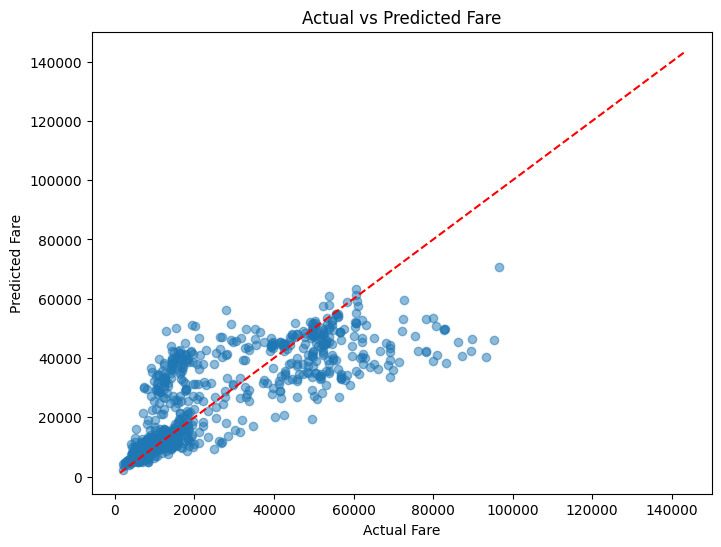

In [230]:
# Remove any non-feature columns (e.g., Predicted_Fare or any other added columns)
af_data_to_predict = af_data.drop(columns=['Predicted_Fare'], errors='ignore')

sampled_data = af_data_to_predict.sample(n=1000, random_state=42)  # random_state ensures reproducibility
y_sampled_pred = HGB_pipe.predict(sampled_data)
sampled_fare = fare.sample(n=1000, random_state=42)

plt.figure(figsize=(8, 6))
plt.scatter(sampled_fare, y_sampled_pred, alpha=0.5)
plt.plot([min(fare), max(fare)], [min(fare), max(fare)], color='red', linestyle='--')
plt.xlabel('Actual Fare')
plt.ylabel('Predicted Fare')
plt.title('Actual vs Predicted Fare')
plt.show()


It seems as though we have an overall good correlation between actual and predicted values. Most points cluster arounf the red dashed line meaning the model is reasonably effective but not perfect. There is some scatter around the red line especially as fare values increase. This indicates that the prediction errors tend to grow for higher fare values and that the model struggles more with these. For fares above 80000 rupees the model seems to underpredict. There are a few noticeable outliers where predicted fares deviate from the actual fares; this can be due to noise in the data and model limitations. There are some areas we can tune in order to improve the model such as more feature engineering such as investigating whether important features are missing or underrepresented, experimenting with other models such as XGBoost, and/or maybe exploring log transform to reduce the impact of large values and improve the fit for higher ranges.